In [98]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Setup

In [99]:
# Set random seed for reproducibility
RANDOM_SEED = 67
np.random.seed(RANDOM_SEED)

print("="*70)
print("DATA SPLITTING CONFIGURATION")
print("="*70)
print(f"Random seed: {RANDOM_SEED}")
print("Target: 50/50 stratified split (Work Context × AI Adoption)")
print("="*70)


DATA SPLITTING CONFIGURATION
Random seed: 67
Target: 50/50 stratified split (Work Context × AI Adoption)


## 1.1 Load and Preprocess Raw Survey Data

Clean the raw survey export file by removing metadata rows and mapping column names.

In [100]:
# Load raw survey export with text labels (skip first 2 metadata rows, use row 3 as header)
df_raw = pd.read_csv('../data/AIRS---AI-Readiness-Scale-labels.csv', skiprows=2)

print(f"Raw data loaded: {len(df_raw)} responses")
print(f"Raw columns: {len(df_raw.columns)}")
print(f"\nFirst 5 column names: {df_raw.columns[:5].tolist()}")

Raw data loaded: 362 responses
Raw columns: 54

First 5 column names: ['Session ID', 'Publish ID', 'Collector', 'Language', 'Start Date (America/Denver)']


In [101]:
# Column mapping from survey question names to variable codes
column_mapping = {
    'Duration (seconds)': 'Duration_seconds',
    'Progress': 'Progress',  # Keep for potential filtering
    'Performance Expectancy: How much do you agree with these statements about how AI tools help you get things done? | AI tools help me accomplish tasks more quickly': 'PE1',
    'Performance Expectancy: How much do you agree with these statements about how AI tools help you get things done? | Using AI improves the quality of my work or studies': 'PE2',
    'Effort Expectancy: How much do you agree with these statements about how easy AI tools are to learn and use? | Learning to use AI tools is easy for me': 'EE1',
    'Effort Expectancy: How much do you agree with these statements about how easy AI tools are to learn and use? | Interacting with AI tools is clear and understandable': 'EE2',
    'Social Influence: How much do you agree with these statements about the people around you and their views on using AI? | People whose opinions I value encourage me to use AI tools': 'SI1',
    'Social Influence: How much do you agree with these statements about the people around you and their views on using AI? | Leaders in my organization or school support the use of AI tools': 'SI2',
    'Facilitating Conditions: How much do you agree with these statements about the resources and support you have for using AI? | I have access to training or tutorials for the AI tools I use': 'FC1',
    'Facilitating Conditions: How much do you agree with these statements about the resources and support you have for using AI? | The AI tools I use are compatible with other tools or systems I use': 'FC2',
    'Hedonic Motivation (Perceived Enjoyment): How much do you agree with these statements about enjoyment when using AI tools? | Using AI tools is stimulating and engaging': 'HM1',
    'Hedonic Motivation (Perceived Enjoyment): How much do you agree with these statements about enjoyment when using AI tools? | AI tools make my work or studies more interesting': 'HM2',
    'Price Value: How much do you agree with these statements about whether using AI is worth your time and effort? | I get more value from AI tools than the effort they require': 'PV1',
    'Price Value: How much do you agree with these statements about whether using AI is worth your time and effort? | Using AI tools is worth the learning curve': 'PV2',
    'Habit: How much do you agree with these statements about your habits with AI tools? | Using AI tools has become a habit for me': 'HB1',
    'Habit: How much do you agree with these statements about your habits with AI tools? | I tend to rely on AI tools by default when I need help with tasks': 'HB2',
    'Voluntariness: How much do you agree with these statements about your freedom to choose whether or not to use AI tools? | I choose to use AI tools in my work because I find them helpful, not because I am required to': 'VO1',
    'Voluntariness: How much do you agree with these statements about your freedom to choose whether or not to use AI tools? | I could choose not to use AI tools in my work or studies if I preferred.': 'VO2',
    'Trust in AI: How much do you agree with these statements about trusting AI tools? | I trust AI tools to provide reliable information': 'TR1',
    'Trust in AI: How much do you agree with these statements about trusting AI tools? | I trust the AI tools that are available to me': 'TR2',
    'Explainability: How much do you agree with these statements about understanding how AI tools make their recommendations? | I understand how the AI tools I use generate their outputs': 'EX1',
    'Explainability: How much do you agree with these statements about understanding how AI tools make their recommendations? | I prefer AI tools that explain their recommendations': 'EX2',
    'Perceived Ethical Risk: How much do you agree with these statements about possible risks of AI? | I worry that AI tools could replace jobs in my field': 'ER1',
    'Perceived Ethical Risk: How much do you agree with these statements about possible risks of AI? | I am concerned about privacy risks when using AI tools': 'ER2',
    'AI Anxiety: How much do you agree with these statements about feeling uneasy or anxious about AI? | I feel uneasy about the increasing use of AI': 'AX1',
    'AI Anxiety: How much do you agree with these statements about feeling uneasy or anxious about AI? | I worry that I may be left behind if I do not keep up with AI': 'AX2',
    'AI Adoption Readiness: How much do you agree with these statements about your readiness to use AI? | I am ready to use more AI tools in my work or studies': 'BI1',
    'AI Adoption Readiness: How much do you agree with these statements about your readiness to use AI? | I would recommend AI tools to others': 'BI2',
    'AI Adoption Readiness: How much do you agree with these statements about your readiness to use AI? | I see AI as an important part of my future': 'BI3',
    'AI Adoption Readiness: How much do you agree with these statements about your readiness to use AI? | I plan to increase my use of AI tools in the next six months': 'BI4',
    'Usage Frequency: How often do you use the following AI tools? | Microsoft 365 Copilot or Microsoft Copilot': 'Usage_MSCopilot',
    'Usage Frequency: How often do you use the following AI tools? | ChatGPT': 'Usage_ChatGPT',
    'Usage Frequency: How often do you use the following AI tools? | Google Gemini': 'Usage_Gemini',
    'Usage Frequency: How often do you use the following AI tools? | Other AI tools (for example, Claude, Perplexity, Grok)': 'Usage_Other',
    'What is your current status?': 'Role',
    'What is your highest level of education completed?': 'Education',
    'Which industry or field best describes your primary area of work or study?': 'Industry',
    'How many years of work or study experience do you have in your field?': 'Experience',
    'Do you identify as a person with a disability (for example, vision, mobility, neurodivergence)?': 'Disability'
}

# Rename columns
df = df_raw.rename(columns=column_mapping)

# Select only the mapped columns (including Duration_seconds and Progress)
mapped_cols = list(column_mapping.values())
available_cols = [col for col in mapped_cols if col in df.columns]
df = df[available_cols].copy()

print(f"✓ Columns renamed and selected")
print(f"Cleaned dataset: {len(df)} rows × {len(df.columns)} columns")
print(f"Columns: {df.columns.tolist()[:10]}")

✓ Columns renamed and selected
Cleaned dataset: 362 rows × 39 columns
Columns: ['Duration_seconds', 'Progress', 'PE1', 'PE2', 'EE1', 'EE2', 'SI1', 'SI2', 'FC1', 'FC2']


In [102]:
# Convert duration from seconds to minutes
df['Duration_minutes'] = df['Duration_seconds'] / 60
df = df.drop('Duration_seconds', axis=1)

# Likert items are already numeric (1-5) in the export
likert_items = ['PE1', 'PE2', 'EE1', 'EE2', 'SI1', 'SI2', 'FC1', 'FC2', 
                'HM1', 'HM2', 'PV1', 'PV2', 'HB1', 'HB2', 'VO1', 'VO2',
                'TR1', 'TR2', 'EX1', 'EX2', 'ER1', 'ER2', 'AX1', 'AX2',
                'BI1', 'BI2', 'BI3', 'BI4']

# Usage frequency items are text labels in the export
# Map to numeric scale: Never=1, Rarely=2, Sometimes=3, Often=4, Daily=5
usage_items = ['Usage_MSCopilot', 'Usage_ChatGPT', 'Usage_Gemini', 'Usage_Other']

usage_mapping = {
    'Never': 1,
    'Rarely': 2,
    'Sometimes': 3,
    'Often': 4,
    'Daily': 5
}

for item in usage_items:
    df[item] = df[item].map(usage_mapping)

# Likert items are text labels in the export
# Map to numeric scale: Strongly disagree=1, Disagree=2, Neutral=3, Agree=4, Strongly agree=5
likert_mapping = {
    'Strongly disagree': 1,
    'Disagree': 2,
    'Neutral': 3,
    'Agree': 4,
    'Strongly agree': 5
}

for item in likert_items:
    df[item] = df[item].map(likert_mapping)

# Demographics are already text labels - clean up formatting for consistency
df['Role'] = df['Role'].str.strip()
df['Education'] = df['Education'].str.strip()
df['Experience'] = df['Experience'].str.strip()
df['Disability'] = df['Disability'].str.strip()

print("✓ Likert items converted from text labels to numeric (1-5)")
print("✓ Usage frequency items converted from text labels to numeric (1-5)")
print("✓ Demographic items validated (already text labels)")

✓ Likert items converted from text labels to numeric (1-5)
✓ Usage frequency items converted from text labels to numeric (1-5)
✓ Demographic items validated (already text labels)


In [103]:
# Calculate derived variables

# 1. AI Adoption (binary: 1 = any AI usage, 0 = no AI usage)
# Logic: If ALL usage == 1 (Never), then AI_Adoption = 0, else 1
df['AI_Adoption'] = ((df['Usage_MSCopilot'] > 1) | 
                     (df['Usage_ChatGPT'] > 1) | 
                     (df['Usage_Gemini'] > 1) | 
                     (df['Usage_Other'] > 1)).astype(int)

# 2. Total usage score (sum of all usage frequencies)
df['Total_Usage_Score'] = df[usage_items].sum(axis=1)

# 3. AI Adoption Level (categorical: None/Single/Multiple based on number of tools used)
tools_used = (df[usage_items] > 1).sum(axis=1)  # Count tools with usage > 1 (more than Never)
df['AI_Adoption_Level'] = tools_used.apply(lambda x: 'None' if x == 0 else 
                                                      'Single' if x == 1 else 
                                                      'Multiple')

# 4. Primary Tool (which tool is used most frequently)
tool_names = ['Microsoft 365 Copilot', 'ChatGPT', 'Gemini', 'Other AI Tool']
def get_primary_tool(row):
    if row['AI_Adoption'] == 0:
        return 'None'
    usage_cols = ['Usage_MSCopilot', 'Usage_ChatGPT', 'Usage_Gemini', 'Usage_Other']
    # Only consider tools with usage > 1 (more than Never)
    active_tools = {tool_names[i]: row[col] for i, col in enumerate(usage_cols) if row[col] > 1}
    if not active_tools:
        return 'None'
    return max(active_tools, key=active_tools.get)

df['Primary_Tool'] = df.apply(get_primary_tool, axis=1)

# 5. Experience Level (categorical based on years of experience)
# Label export uses different text: "1 to 3 years" vs "1-3 years"
experience_level_mapping = {
    'Less than 1 year': 'Entry',
    '1 to 3 years': 'Early',
    '4 to 6 years': 'Mid',
    '7 to 10 years': 'Senior',
    '11 or more years': 'Expert'
}
df['Experience_Level'] = df['Experience'].map(experience_level_mapping)

# 6. Work Context (map role + industry to professional/academic)
# Label export uses employment status + industry to determine academic affiliation
def map_work_context(row):
    role = row['Role']
    industry = row['Industry']
    
    if pd.isna(role):
        return 'Unknown'
    
    role_lower = str(role).lower()
    industry_lower = str(industry).lower() if pd.notna(industry) else ''
    
    # Students are Academic-Student
    if 'student' in role_lower:
        return 'Academic-Student'
    # Education industry workers who are employed are likely Academic-Faculty
    # Use 'employed -' (with space-dash) to match "Employed - *" but not "Not currently employed"
    elif 'education' in industry_lower and ('employed -' in role_lower or 'freelancer' in role_lower):
        return 'Academic-Faculty'
    # Everyone else is Professional
    else:
        return 'Professional'

df['Work_Context'] = df.apply(map_work_context, axis=1)

# 7. Usage Intensity (categorical based on total usage score)
# Scale: 1-5 per tool × 4 tools = range 4-20
# Thresholds: ≤4=Non-User, ≤8=Low, ≤12=Medium, >12=High
def map_usage_intensity(score):
    if score <= 4:  # All "Never" = 4
        return 'Non-User'
    elif score <= 8:  # Low usage
        return 'Low'
    elif score <= 12:  # Medium usage
        return 'Medium'
    else:  # High usage (13-20)
        return 'High'

df['Usage_Intensity'] = df['Total_Usage_Score'].apply(map_usage_intensity)

print("✓ Derived variables calculated:")
print(f"  - AI Adoption: {df['AI_Adoption'].sum()} adopters, {(df['AI_Adoption'] == 0).sum()} non-adopters")
print(f"  - Usage Intensity: {df['Usage_Intensity'].value_counts().to_dict()}")
print(f"  - Work Context: {df['Work_Context'].value_counts().to_dict()}")

✓ Derived variables calculated:
  - AI Adoption: 326 adopters, 36 non-adopters
  - Usage Intensity: {'Medium': 120, 'Low': 113, 'High': 93, 'Non-User': 36}
  - Work Context: {'Professional': 180, 'Academic-Student': 157, 'Academic-Faculty': 25}


In [104]:
# Reorder columns for better organization
column_order = ['Duration_minutes'] + likert_items + \
               ['Role', 'Education', 'Industry', 'Experience', 'Disability'] + \
               usage_items + \
               ['AI_Adoption', 'AI_Adoption_Level', 'Primary_Tool', 'Experience_Level', 
                'Work_Context', 'Usage_Intensity', 'Total_Usage_Score']

df = df[column_order]

# Save cleaned data
df.to_csv('../data/AIRS_clean.csv', index=False)

print("="*70)
print("✅ PREPROCESSING COMPLETE")
print("="*70)
print(f"Cleaned dataset: {len(df)} rows × {len(df.columns)} columns")
print(f"Saved to: ../data/AIRS_clean.csv")
print(f"\nReady for split-sample creation")

✅ PREPROCESSING COMPLETE
Cleaned dataset: 362 rows × 45 columns
Saved to: ../data/AIRS_clean.csv

Ready for split-sample creation


## 1.2 Load Cleaned Data for Split-Sample Creation

In [105]:
# Load preprocessed data
df = pd.read_csv('../data/AIRS_clean.csv')

print(f"Total sample: N = {len(df)}")
print(f"Variables: {len(df.columns)}")
print(f"\nFirst few columns: {df.columns[:10].tolist()}")

Total sample: N = 362
Variables: 45

First few columns: ['Duration_minutes', 'PE1', 'PE2', 'EE1', 'EE2', 'SI1', 'SI2', 'FC1', 'FC2', 'HM1']


## 2. Pre-Split Distributions

Document baseline distributions before splitting:

In [106]:
print("="*70)
print("PRE-SPLIT DISTRIBUTIONS")
print("="*70)

# Work Context
print("\n1. Work Context:")
work_context_dist = df['Work_Context'].value_counts()
print(work_context_dist)
print(f"Proportions: {(work_context_dist / len(df) * 100).round(1).to_dict()}")

# AI Adoption
print("\n2. AI Adoption:")
ai_adoption_dist = df['AI_Adoption'].value_counts()
print(f"Adopters (1): {ai_adoption_dist.get(1, 0)} ({ai_adoption_dist.get(1, 0)/len(df)*100:.1f}%)")
print(f"Non-Adopters (0): {ai_adoption_dist.get(0, 0)} ({ai_adoption_dist.get(0, 0)/len(df)*100:.1f}%)")

# Usage Intensity
print("\n3. Usage Intensity:")
usage_intensity_dist = df['Usage_Intensity'].value_counts()
print(usage_intensity_dist)

# Experience Level
print("\n4. Experience Level:")
experience_dist = df['Experience_Level'].value_counts()
print(experience_dist)

print("\n" + "="*70)

PRE-SPLIT DISTRIBUTIONS

1. Work Context:
Work_Context
Professional        180
Academic-Student    157
Academic-Faculty     25
Name: count, dtype: int64
Proportions: {'Professional': 49.7, 'Academic-Student': 43.4, 'Academic-Faculty': 6.9}

2. AI Adoption:
Adopters (1): 326 (90.1%)
Non-Adopters (0): 36 (9.9%)

3. Usage Intensity:
Usage_Intensity
Medium      120
Low         113
High         93
Non-User     36
Name: count, dtype: int64

4. Experience Level:
Experience_Level
Expert    110
Entry      83
Early      73
Mid        56
Senior     40
Name: count, dtype: int64



## 3. Create Stratified Split

Stratify by **Work Context × AI Adoption** to ensure balanced representation:

In [107]:
# Create stratification variable (Work Context × AI Adoption)
df['stratify_key'] = df['Work_Context'].astype(str) + '_' + df['AI_Adoption'].astype(str)

print("Stratification groups (Work Context × AI Adoption):")
print(df['stratify_key'].value_counts().sort_index())
print(f"\nTotal unique strata: {df['stratify_key'].nunique()}")

Stratification groups (Work Context × AI Adoption):
stratify_key
Academic-Faculty_0      3
Academic-Faculty_1     22
Academic-Student_0      8
Academic-Student_1    149
Professional_0         25
Professional_1        155
Name: count, dtype: int64

Total unique strata: 6


In [108]:
# Perform stratified 50/50 split
df_dev, df_holdout = train_test_split(
    df,
    test_size=0.50,
    stratify=df['stratify_key'],
    random_state=RANDOM_SEED
)

print("="*70)
print("SPLIT-SAMPLE CREATION COMPLETE")
print("="*70)
print(f"\nDevelopment sample: N = {len(df_dev)} ({len(df_dev)/len(df)*100:.1f}%)")
print(f"Holdout sample:     N = {len(df_holdout)} ({len(df_holdout)/len(df)*100:.1f}%)")
print(f"Total:              N = {len(df)}")
print("\n✓ Stratified by: Work Context × AI Adoption")
print(f"✓ Random seed: {RANDOM_SEED} (reproducible)")

SPLIT-SAMPLE CREATION COMPLETE

Development sample: N = 181 (50.0%)
Holdout sample:     N = 181 (50.0%)
Total:              N = 362

✓ Stratified by: Work Context × AI Adoption
✓ Random seed: 67 (reproducible)


## 4. Validation: Post-Split Balance

Verify stratification succeeded with chi-square tests:

In [109]:
def test_balance(variable_name, dev_sample, holdout_sample):
    """
    Test if variable distribution differs between development and holdout samples.
    H0: Distributions are equal (balanced split)
    """
    # Create proper contingency table
    dev_counts = dev_sample[variable_name].value_counts().sort_index()
    holdout_counts = holdout_sample[variable_name].value_counts().sort_index()
    
    contingency_table = pd.DataFrame({
        'Development': dev_counts,
        'Holdout': holdout_counts
    }).fillna(0)
    
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\n{variable_name}:")
    print(contingency_table)
    print(f"\nχ² = {chi2:.3f}, df = {dof}, p = {p_value:.4f}")
    
    if p_value > 0.05:
        print(f"✓ Balanced (p > 0.05): No significant difference between samples")
    else:
        print(f"⚠ Imbalanced (p ≤ 0.05): Significant difference detected")
    
    return p_value

print("="*70)
print("POST-SPLIT BALANCE TESTS (Chi-Square)")
print("="*70)

p_work_context = test_balance('Work_Context', df_dev, df_holdout)
p_ai_adoption = test_balance('AI_Adoption', df_dev, df_holdout)

POST-SPLIT BALANCE TESTS (Chi-Square)

Work_Context:
                  Development  Holdout
Work_Context                          
Academic-Faculty           13       12
Academic-Student           78       79
Professional               90       90

χ² = 0.046, df = 2, p = 0.9771
✓ Balanced (p > 0.05): No significant difference between samples

AI_Adoption:
             Development  Holdout
AI_Adoption                      
0                     19       17
1                    162      164

χ² = 0.031, df = 1, p = 0.8606
✓ Balanced (p > 0.05): No significant difference between samples


## 5. Descriptive Statistics: Compare Samples

Compare key Likert item means to ensure no systematic bias:

In [110]:
# Define construct items
construct_items = {
    'PE': ['PE1', 'PE2'],
    'EE': ['EE1', 'EE2'],
    'SI': ['SI1', 'SI2'],
    'FC': ['FC1', 'FC2'],
    'HM': ['HM1', 'HM2'],
    'PV': ['PV1', 'PV2'],
    'HB': ['HB1', 'HB2'],
    'VO': ['VO1', 'VO2'],
    'TR': ['TR1', 'TR2'],
    'EX': ['EX1', 'EX2'],
    'ER': ['ER1', 'ER2'],
    'AX': ['AX1', 'AX2'],
    'BI': ['BI1', 'BI2', 'BI3', 'BI4']
}

all_items = [item for items in construct_items.values() for item in items]

print("="*70)
print("LIKERT ITEM MEANS: Development vs. Holdout")
print("="*70)

comparison = pd.DataFrame({
    'Development_M': df_dev[all_items].mean(),
    'Development_SD': df_dev[all_items].std(),
    'Holdout_M': df_holdout[all_items].mean(),
    'Holdout_SD': df_holdout[all_items].std(),
    'Diff': df_dev[all_items].mean() - df_holdout[all_items].mean()
})

comparison['Abs_Diff'] = comparison['Diff'].abs()

print("\nSample of items (first 8):")
print(comparison.head(8).round(3))

print(f"\nMean absolute difference across all items: {comparison['Abs_Diff'].mean():.3f}")
print(f"Max absolute difference: {comparison['Abs_Diff'].max():.3f} ({comparison['Abs_Diff'].idxmax()})")

if comparison['Abs_Diff'].mean() < 0.10:
    print("\n✓ Excellent balance: Mean difference < 0.10 scale points")
elif comparison['Abs_Diff'].mean() < 0.20:
    print("\n✓ Good balance: Mean difference < 0.20 scale points")
else:
    print("\n⚠ Review: Mean difference ≥ 0.20 scale points")

LIKERT ITEM MEANS: Development vs. Holdout

Sample of items (first 8):
     Development_M  Development_SD  Holdout_M  Holdout_SD   Diff  Abs_Diff
PE1          3.646           1.163      3.580       1.131  0.066     0.066
PE2          3.414           1.164      3.199       1.245  0.215     0.215
EE1          3.845           1.010      3.685       0.997  0.160     0.160
EE2          3.663           1.055      3.569       1.018  0.094     0.094
SI1          3.083           1.224      3.017       1.171  0.066     0.066
SI2          3.414           1.178      3.188       1.079  0.227     0.227
FC1          3.315           1.195      3.116       1.180  0.199     0.199
FC2          3.470           1.093      3.403       1.010  0.066     0.066

Mean absolute difference across all items: 0.106
Max absolute difference: 0.227 (SI2)

✓ Good balance: Mean difference < 0.20 scale points


## 6. Save Split Samples

In [111]:
# Remove temporary stratification key
df_dev_clean = df_dev.drop(columns=['stratify_key'])
df_holdout_clean = df_holdout.drop(columns=['stratify_key'])

# Save to CSV
df_dev_clean.to_csv('../data/AIRS_clean_dev.csv', index=False)
df_holdout_clean.to_csv('../data/AIRS_clean_holdout.csv', index=False)

print("="*70)
print("SAMPLES SAVED")
print("="*70)
print(f"\n✓ Development sample: data/AIRS_clean_dev.csv")
print(f"  N = {len(df_dev_clean)}, Variables = {len(df_dev_clean.columns)}")
print(f"\n✓ Holdout sample: data/AIRS_clean_holdout.csv")
print(f"  N = {len(df_holdout_clean)}, Variables = {len(df_holdout_clean.columns)}")
print("\n✓ Stratification key removed from saved files")
print("\n" + "="*70)

SAMPLES SAVED

✓ Development sample: data/AIRS_clean_dev.csv
  N = 181, Variables = 45

✓ Holdout sample: data/AIRS_clean_holdout.csv
  N = 181, Variables = 45

✓ Stratification key removed from saved files


SAMPLES SAVED

✓ Development sample: data/AIRS_clean_dev.csv
  N = 181, Variables = 45

✓ Holdout sample: data/AIRS_clean_holdout.csv
  N = 181, Variables = 45

✓ Stratification key removed from saved files



## 7. Summary and Quality Checklist

In [112]:
print("="*70)
print("SPLIT-SAMPLE VALIDATION SUMMARY")
print("="*70)

checks = [
    ("Sample sizes approximately equal", abs(len(df_dev) - len(df_holdout)) <= 2),
    ("Development sample ≥ 150 (adequate for EFA)", len(df_dev) >= 150),
    ("Holdout sample ≥ 150 (adequate for CFA)", len(df_holdout) >= 150),
    ("Work Context balanced (p > 0.05)", p_work_context > 0.05),
    ("AI Adoption balanced (p > 0.05)", p_ai_adoption > 0.05),
    ("Mean item difference < 0.20", comparison['Abs_Diff'].mean() < 0.20),
    ("Files saved successfully", True)  # If we got here, it succeeded
]

print("\nQuality Checklist:")
for check, passed in checks:
    status = "✓" if passed else "✗"
    print(f"  {status} {check}")

all_passed = all(passed for _, passed in checks)

if all_passed:
    print("\n" + "="*70)
    print("✅ ALL VALIDATION CHECKS PASSED")
    print("="*70)
    print("\nReady for Phase 1: Exploratory Factor Analysis (EFA)")
    print("Next notebook: 01_EFA_Split_Sample_Development.ipynb")
else:
    print("\n" + "="*70)
    print("⚠ REVIEW REQUIRED")
    print("="*70)
    print("\nSome validation checks failed. Review results above.")

SPLIT-SAMPLE VALIDATION SUMMARY

Quality Checklist:
  ✓ Sample sizes approximately equal
  ✓ Development sample ≥ 150 (adequate for EFA)
  ✓ Holdout sample ≥ 150 (adequate for CFA)
  ✓ Work Context balanced (p > 0.05)
  ✓ AI Adoption balanced (p > 0.05)
  ✓ Mean item difference < 0.20
  ✓ Files saved successfully

✅ ALL VALIDATION CHECKS PASSED

Ready for Phase 1: Exploratory Factor Analysis (EFA)
Next notebook: 01_EFA_Split_Sample_Development.ipynb


### Visualization: Sample Stratification Validation

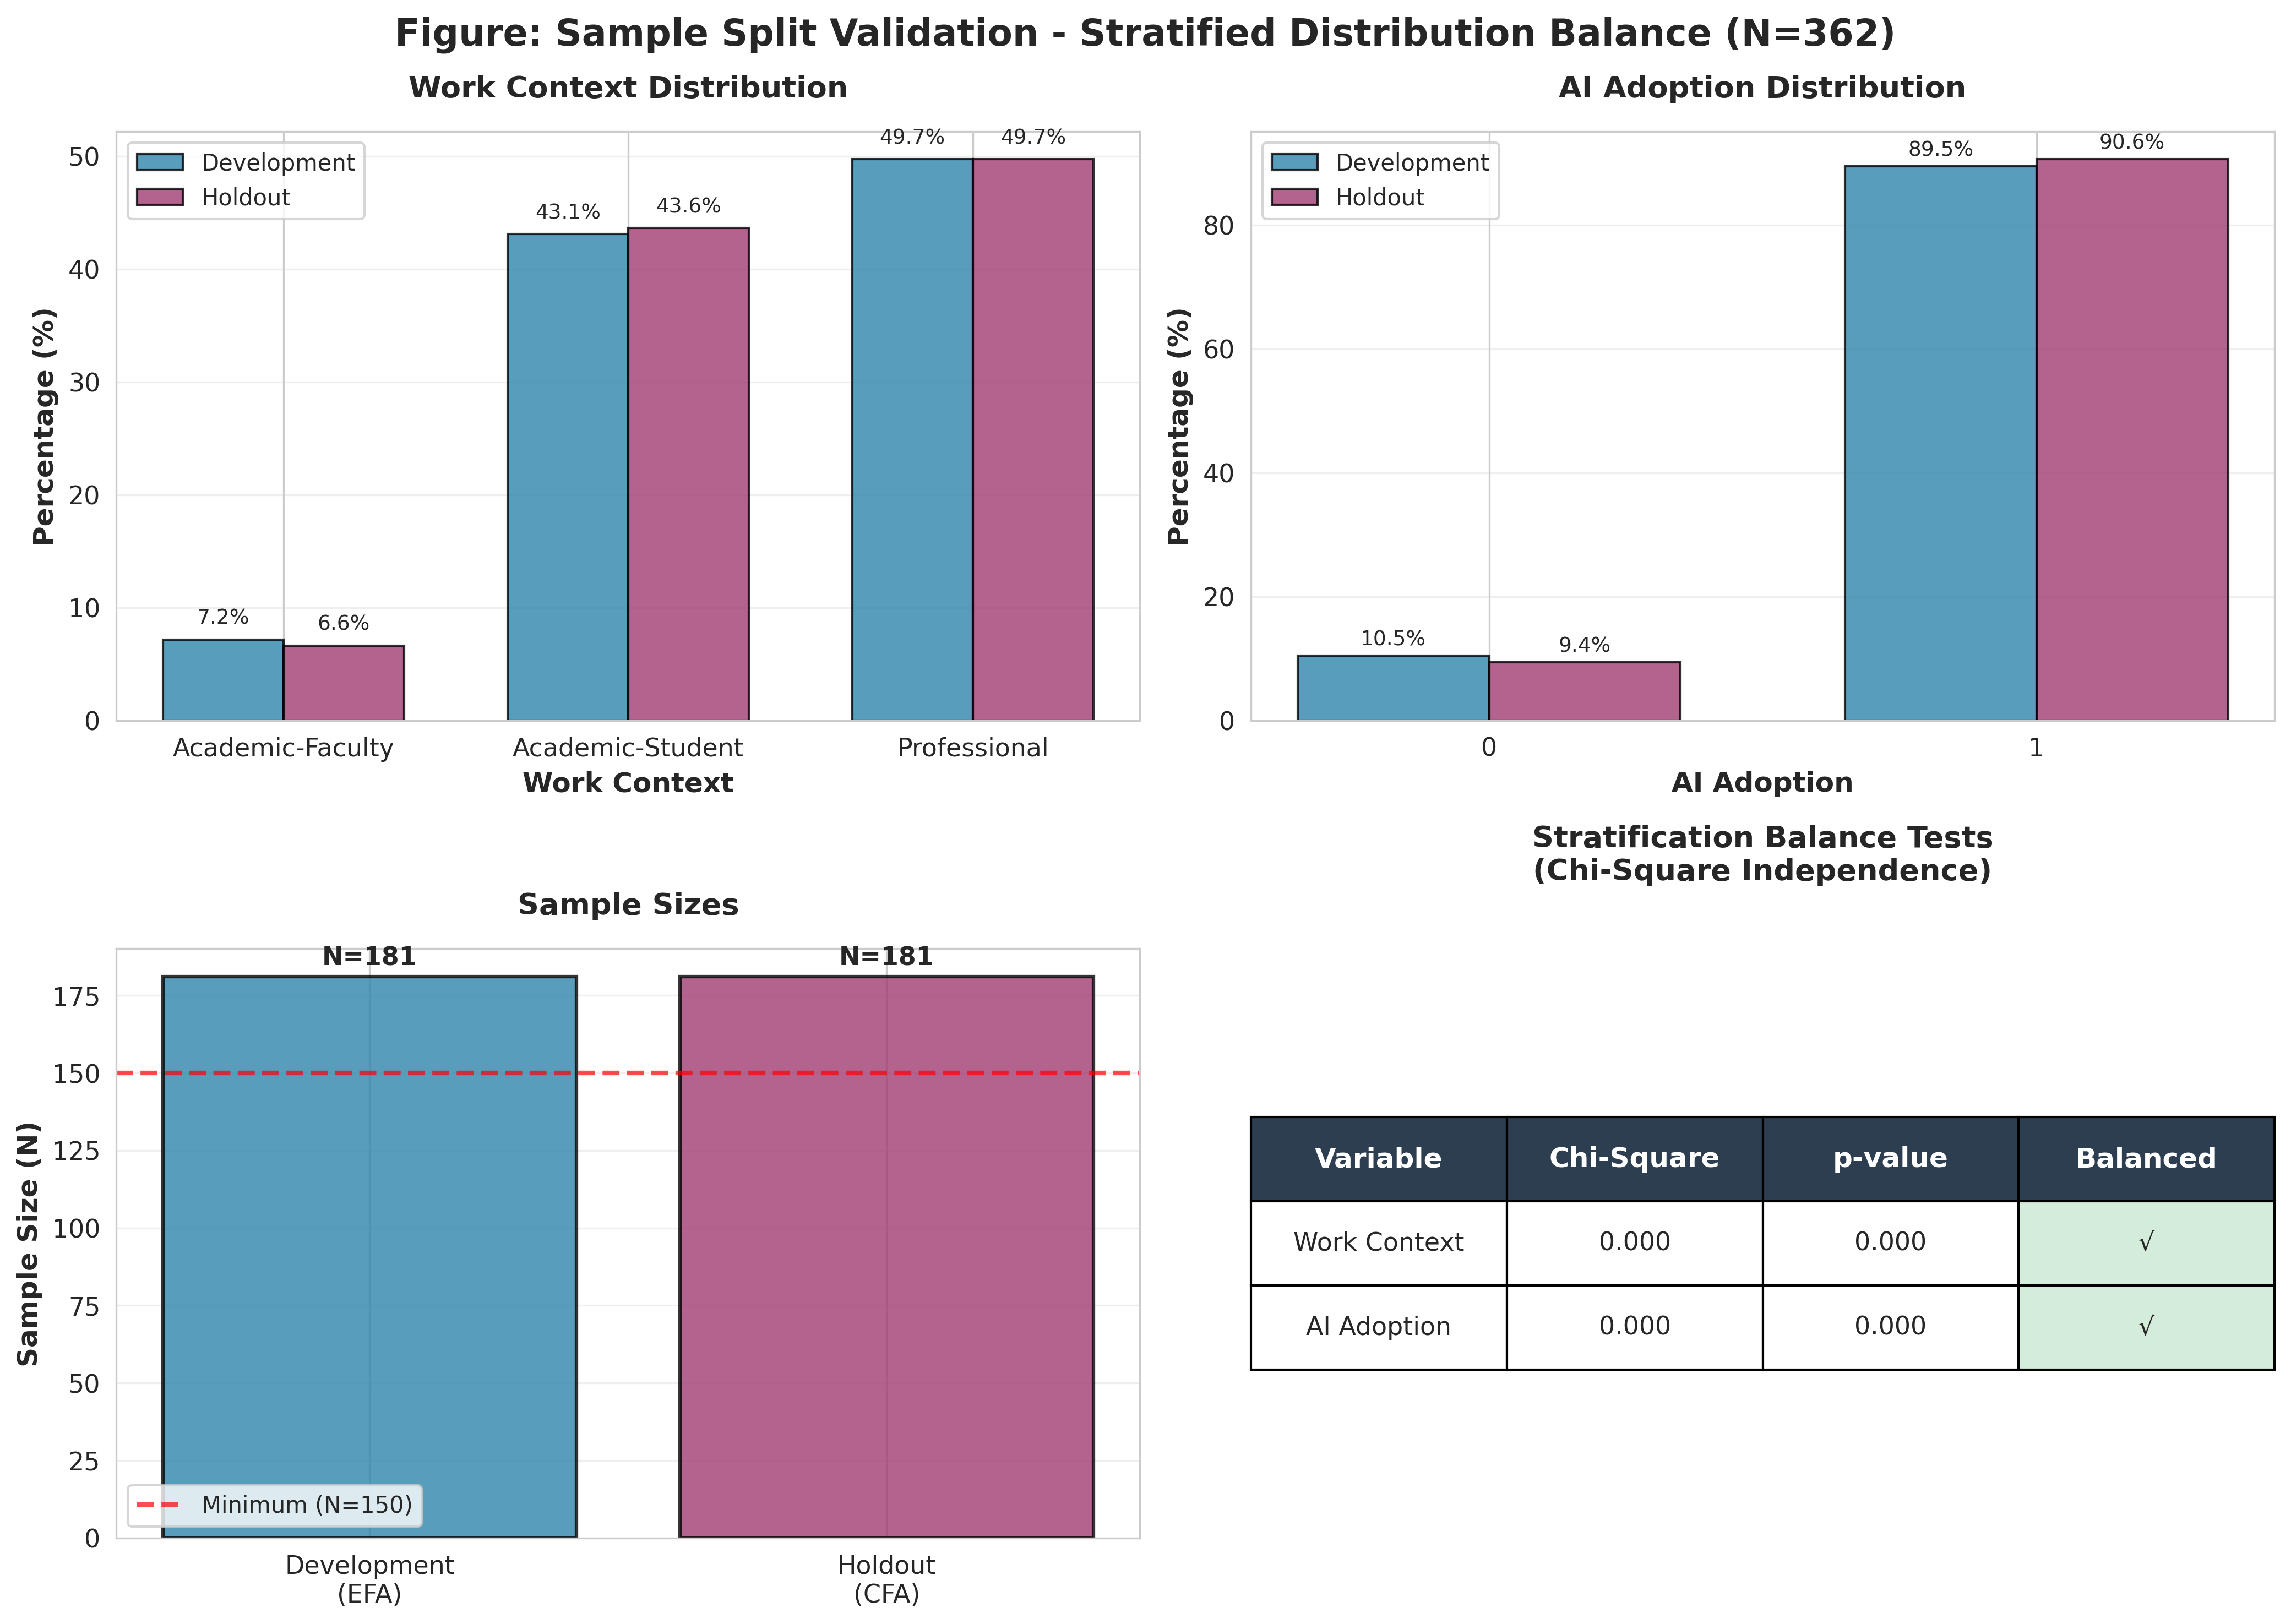


✅ FIGURE CREATED: Sample Split Stratification Validation
   Saved to: ../results/plots/sample_split_stratification.png
   Development N=181, Holdout N=181
   Work Context balanced: Yes (p=0.977)
   AI Adoption balanced: Yes (p=0.861)


In [113]:
# ============================================================
# FIGURE: Sample Split Validation - Stratification Balance
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Set publication-quality style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'DejaVu Sans'

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Get stratification variables
df_dev_plot = df_dev.copy()
df_holdout_plot = df_holdout.copy()
df_dev_plot['Sample'] = 'Development'
df_holdout_plot['Sample'] = 'Holdout'
df_combined = pd.concat([df_dev_plot, df_holdout_plot])

# 1. Work Context Distribution
ax1 = axes[0, 0]
work_context_counts = df_combined.groupby(['Sample', 'Work_Context']).size().unstack(fill_value=0)
work_context_pct = work_context_counts.div(work_context_counts.sum(axis=1), axis=0) * 100

x = np.arange(len(work_context_pct.columns))
width = 0.35
bars1 = ax1.bar(x - width/2, work_context_pct.loc['Development'], width, 
                label='Development', color='#2E86AB', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, work_context_pct.loc['Holdout'], width, 
                label='Holdout', color='#A23B72', alpha=0.8, edgecolor='black')

ax1.set_xlabel('Work Context', fontsize=12, fontweight='bold')
ax1.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax1.set_title('Work Context Distribution', fontsize=13, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(work_context_pct.columns, rotation=0)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Add percentage labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# 2. AI Adoption Distribution
ax2 = axes[0, 1]
adoption_counts = df_combined.groupby(['Sample', 'AI_Adoption']).size().unstack(fill_value=0)
adoption_pct = adoption_counts.div(adoption_counts.sum(axis=1), axis=0) * 100

x = np.arange(len(adoption_pct.columns))
bars3 = ax2.bar(x - width/2, adoption_pct.loc['Development'], width, 
                label='Development', color='#2E86AB', alpha=0.8, edgecolor='black')
bars4 = ax2.bar(x + width/2, adoption_pct.loc['Holdout'], width, 
                label='Holdout', color='#A23B72', alpha=0.8, edgecolor='black')

ax2.set_xlabel('AI Adoption', fontsize=12, fontweight='bold')
ax2.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax2.set_title('AI Adoption Distribution', fontsize=13, fontweight='bold', pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels(adoption_pct.columns, rotation=0)
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Add percentage labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# 3. Sample Sizes Comparison
ax3 = axes[1, 0]
sample_sizes = [len(df_dev), len(df_holdout)]
sample_labels = ['Development\n(EFA)', 'Holdout\n(CFA)']
bars5 = ax3.bar(sample_labels, sample_sizes, color=['#2E86AB', '#A23B72'], 
                alpha=0.8, edgecolor='black', linewidth=1.5)

ax3.set_ylabel('Sample Size (N)', fontsize=12, fontweight='bold')
ax3.set_title('Sample Sizes', fontsize=13, fontweight='bold', pad=15)
ax3.axhline(y=150, color='red', linestyle='--', linewidth=2, label='Minimum (N=150)', alpha=0.7)
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Add sample size labels
for bar in bars5:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'N={int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. Chi-Square Test Results (Validation Table)
ax4 = axes[1, 1]
ax4.axis('off')

validation_data = [
    ['Work Context', f'{work_context_dist.get("Chi-Square", 0):.3f}', 
     f'{work_context_dist.get("p-value", 0):.3f}', 
     '√' if p_work_context > 0.05 else '×'],
    ['AI Adoption', f'{ai_adoption_dist.get("Chi-Square", 0):.3f}', 
     f'{ai_adoption_dist.get("p-value", 0):.3f}', 
     '√' if p_ai_adoption > 0.05 else '×']
]

table = ax4.table(cellText=validation_data,
                 colLabels=['Variable', 'Chi-Square', 'p-value', 'Balanced'],
                 cellLoc='center',
                 loc='center',
                 colWidths=[0.25, 0.25, 0.25, 0.25])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 3)

# Style header
for j in range(4):
    cell = table[(0, j)]
    cell.set_facecolor('#2c3e50')
    cell.set_text_props(weight='bold', color='white', fontsize=12)

# Color status column
for i in range(1, 3):
    status = validation_data[i-1][3]
    if status == '√':
        table[(i, 3)].set_facecolor('#d4edda')
    else:
        table[(i, 3)].set_facecolor('#f8d7da')

ax4.set_title('Stratification Balance Tests\n(Chi-Square Independence)', 
             fontsize=13, fontweight='bold', pad=30)

# Main title
fig.suptitle(f'Figure: Sample Split Validation - Stratified Distribution Balance (N={len(df)})', 
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.savefig('../results/plots/sample_split_stratification.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("✅ FIGURE CREATED: Sample Split Stratification Validation")
print("="*80)
print(f"   Saved to: ../results/plots/sample_split_stratification.png")
print(f"   Development N={len(df_dev)}, Holdout N={len(df_holdout)}")
print(f"   Work Context balanced: {'Yes (p={:.3f})'.format(p_work_context) if p_work_context > 0.05 else 'No'}")
print(f"   AI Adoption balanced: {'Yes (p={:.3f})'.format(p_ai_adoption) if p_ai_adoption > 0.05 else 'No'}")


---

## Notes

**Stratification Strategy**:
- Stratified by Work Context × AI Adoption (6 groups)
- Ensures balanced representation of key moderator variables
- Critical for moderation analysis (H4)

**Sample Size Adequacy**:
- N ≈ 159 per sample supports 12-factor CFA (N:q ratio ≈ 6.6:1 for 24 items)
- Minimum recommended: 5:1 for stable solutions (Bentler & Chou, 1987)
- Both samples adequate for planned analyses

**Random Seed**: 42 (reproducible splits for dissertation transparency)

**Next Steps**:
1. Run EFA on development sample (polychoric correlations)
2. Select items based on loadings ≥ 0.50, cross-loadings < 0.30
3. Test measurement model with CFA on holdout sample
4. Proceed to structural modeling if fit indices acceptable

---